In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.font_manager as font_manager
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
from sklearn.metrics.pairwise import euclidean_distances
from numpy import linalg

import ast

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

from scipy.optimize import Bounds, minimize, minimize_scalar

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [64]:
meta_df = pd.read_csv("prolific_participant_meta_df.csv", index_col=False)

In [66]:
meta_df

,age,gender,race,id,5dcs_je_1,5dcs_je_2,5dcs_je_3,5dcs_je_4,5dcs_je_5,5dcs_ds_1,...,soes_8,soes_9,soes_10,curiosity_je,curiosity_ds,curiosity_st,curiosity_sc,curiosity_ts,bis,soes
0,64,Male,Caucasian (or White),0,5,1,1,3,3,4,...,5,2,1,2.6,5.6,5.2,4.6,2.2,52,3.3
1,51,Male,African American (or Black),1,5,5,6,6,7,2,...,4,2,2,5.8,5.4,3.4,1.6,1.6,46,2.7
2,51,Male,Caucasian (or White),2,2,2,1,1,4,1,...,3,5,1,2.0,2.2,2.2,2.0,1.2,69,2.4
3,36,Female,Mixed race or ethnicity,3,2,3,1,6,7,2,...,2,5,2,3.8,3.0,3.2,6.6,2.4,60,3.1
4,51,Female,Asian,4,3,5,3,6,7,5,...,5,2,2,4.8,5.2,3.4,6.2,1.8,50,3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,33,Male,Hispanic,245,2,2,2,6,6,6,...,2,5,1,3.6,5.0,1.2,5.2,1.8,65,2.4
246,35,Female,Caucasian (or White),246,6,5,6,5,6,7,...,2,4,1,5.6,5.6,4.8,2.0,3.2,70,2.4
247,55,Female,Caucasian (or White),247,7,5,5,6,7,2,...,4,3,1,6.0,5.4,3.2,4.2,1.8,61,2.8
248,35,Male,Mixed race or ethnicity,248,5,2,5,7,5,3,...,5,5,5,4.8,4.4,1.8,5.2,2.2,91,3.5


In [67]:
ids = meta_df.id.tolist()

In [162]:
import json
with open('/home/jasongong/Downloads/id_recode.json', 'w') as fp:
    json.dump({i[0]: str(i[1]) for i in id_recode.items()}, fp)

In [33]:
id_recode = {pd.factorize(meta_df.id)[1].tolist()[i]: pd.factorize(meta_df.id)[0][i] for i in range(meta_df.shape[0])}
recode_id = {pd.factorize(meta_df.id)[0][i]: pd.factorize(meta_df.id)[1].tolist()[i] for i in range(meta_df.shape[0])}

In [25]:
signal_detection_columns = ["participant", "recall_check_mouse.time", "recall_check_mouse.clicked_name", "recall_check_option_name"]

signal_detection_df = []
for file in files:
    temp = pd.read_csv(file)
    
    read_books = ast.literal_eval(temp["mouse.clicked_name"].dropna().iloc[-1])
    temp = temp[signal_detection_columns].dropna().reset_index(drop=True)
    temp.columns = ["id", "rt", "response", "book"]
    
    assert temp.shape[0] == 16
    temp["correct_answer"] = temp["book"].isin(read_books)
    
    temp["response"] = temp.response.str.split("_").str[2].map({"yes": True, "no": False})
    temp["book"] = temp.book.str.split("_").str[1]

    temp["correct"] = temp["correct_answer"] == temp["response"]
    signal_detection_df.append(temp)

signal_detection_df = pd.concat(signal_detection_df).reset_index(drop=True)

In [35]:
signal_detection_df["id"] = signal_detection_df["id"].map(id_recode)

In [37]:
signal_detection_df.to_csv("signal_detection/signal_detection_df.csv")

In [45]:
signal_detection_df = pd.read_csv("signal_detection/signal_detection_results.csv")

In [68]:
signal_detection_df

,Unnamed: 0,id,total_correct,total_hit,total_fa,aprime,dprime
0,1,0,15,7,0,0.968750,inf
1,2,1,11,4,1,0.794643,1.150349
2,3,2,15,7,0,0.968750,inf
3,4,3,16,8,0,1.000000,inf
4,5,4,16,8,0,1.000000,inf
...,...,...,...,...,...,...,...
245,246,245,15,7,0,0.968750,inf
246,247,246,16,8,0,1.000000,inf
247,248,247,16,8,0,1.000000,inf
248,249,248,16,8,0,1.000000,inf


<Axes: >

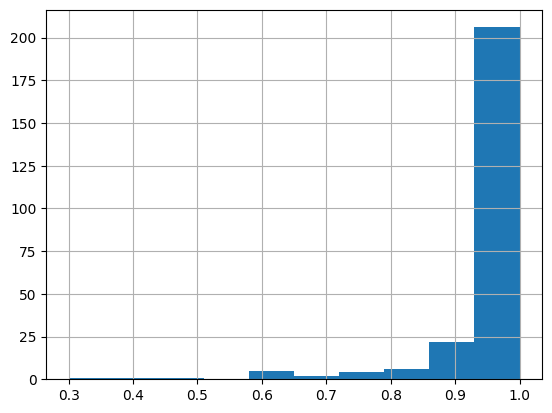

In [69]:
signal_detection_df.aprime.hist()

In [70]:
filtered_ids = signal_detection_df[signal_detection_df.aprime > 0.5].id.tolist()

In [71]:
len(filtered_ids)

245

In [72]:
meta_df_filtered = meta_df[meta_df.id.isin(filtered_ids)]

In [73]:
meta_df_filtered

,age,gender,race,id,5dcs_je_1,5dcs_je_2,5dcs_je_3,5dcs_je_4,5dcs_je_5,5dcs_ds_1,...,soes_8,soes_9,soes_10,curiosity_je,curiosity_ds,curiosity_st,curiosity_sc,curiosity_ts,bis,soes
0,64,Male,Caucasian (or White),0,5,1,1,3,3,4,...,5,2,1,2.6,5.6,5.2,4.6,2.2,52,3.3
1,51,Male,African American (or Black),1,5,5,6,6,7,2,...,4,2,2,5.8,5.4,3.4,1.6,1.6,46,2.7
2,51,Male,Caucasian (or White),2,2,2,1,1,4,1,...,3,5,1,2.0,2.2,2.2,2.0,1.2,69,2.4
3,36,Female,Mixed race or ethnicity,3,2,3,1,6,7,2,...,2,5,2,3.8,3.0,3.2,6.6,2.4,60,3.1
4,51,Female,Asian,4,3,5,3,6,7,5,...,5,2,2,4.8,5.2,3.4,6.2,1.8,50,3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,33,Male,Hispanic,245,2,2,2,6,6,6,...,2,5,1,3.6,5.0,1.2,5.2,1.8,65,2.4
246,35,Female,Caucasian (or White),246,6,5,6,5,6,7,...,2,4,1,5.6,5.6,4.8,2.0,3.2,70,2.4
247,55,Female,Caucasian (or White),247,7,5,5,6,7,2,...,4,3,1,6.0,5.4,3.2,4.2,1.8,61,2.8
248,35,Male,Mixed race or ethnicity,248,5,2,5,7,5,3,...,5,5,5,4.8,4.4,1.8,5.2,2.2,91,3.5


In [74]:
reliability_df = meta_df_filtered[['5dcs_je_1',
 '5dcs_je_2',
 '5dcs_je_3',
 '5dcs_je_4',
 '5dcs_je_5',
 '5dcs_ds_1',
 '5dcs_ds_2',
 '5dcs_ds_3',
 '5dcs_ds_4',
 '5dcs_ds_5',
 '5dcs_st_1',
 '5dcs_st_2',
 '5dcs_st_3',
 '5dcs_st_4',
 '5dcs_st_5',
 '5dcs_sc_1',
 '5dcs_sc_2',
 '5dcs_sc_3',
 '5dcs_sc_4',
 '5dcs_sc_5',
 '5dcs_ts_1',
 '5dcs_ts_2',
 '5dcs_ts_3',
 '5dcs_ts_4',
 '5dcs_ts_5']]

In [75]:
reliability_df

,5dcs_je_1,5dcs_je_2,5dcs_je_3,5dcs_je_4,5dcs_je_5,5dcs_ds_1,5dcs_ds_2,5dcs_ds_3,5dcs_ds_4,5dcs_ds_5,...,5dcs_sc_1,5dcs_sc_2,5dcs_sc_3,5dcs_sc_4,5dcs_sc_5,5dcs_ts_1,5dcs_ts_2,5dcs_ts_3,5dcs_ts_4,5dcs_ts_5
0,5,1,1,3,3,4,5,6,7,6,...,4,3,5,5,6,3,2,1,4,1
1,5,5,6,6,7,2,5,7,7,6,...,1,2,2,1,2,4,1,1,1,1
2,2,2,1,1,4,1,1,2,1,6,...,2,1,2,4,1,1,1,1,2,1
3,2,3,1,6,7,2,3,2,1,7,...,7,7,6,7,6,2,2,2,5,1
4,3,5,3,6,7,5,5,5,4,7,...,6,6,6,6,7,2,1,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2,2,2,6,6,6,7,2,3,7,...,5,6,5,5,5,2,1,2,2,2
246,6,5,6,5,6,7,6,6,6,3,...,3,3,1,1,2,3,5,2,5,1
247,7,5,5,6,7,2,5,7,6,7,...,4,7,3,4,3,2,2,1,2,2
248,5,2,5,7,5,3,4,3,6,6,...,4,6,7,2,7,1,2,1,3,4


In [76]:
import pingouin as pg

In [77]:
print(pg.cronbach_alpha(data=reliability_df))
print(pg.cronbach_alpha(data=reliability_df[curosity_je_var]))
print(pg.cronbach_alpha(data=reliability_df[curosity_ds_var]))
print(pg.cronbach_alpha(data=reliability_df[curosity_ts_var]))
print(pg.cronbach_alpha(data=reliability_df[curosity_sc_var]))
print(pg.cronbach_alpha(data=reliability_df[curosity_st_var]))

(0.8220775792544083, array([0.788, 0.853]))
(0.7876303682336625, array([0.742, 0.827]))
(0.7735210420860689, array([0.725, 0.815]))
(0.7910825681642951, array([0.747, 0.83 ]))
(0.83256837863116, array([0.797, 0.864]))
(0.8538690412576609, array([0.823, 0.881]))


In [135]:
behavioral_df = pd.read_csv("behavioral_df.csv")

In [136]:
behavioral_df

,id,choice,reading_time,enjoyment,uncertainty,age,gender,race,5dcs_je_1,5dcs_je_2,...,soes_10,curiosity_je,curiosity_ds,curiosity_st,curiosity_sc,curiosity_ts,bis,soes,choice_index,enjoyment_new
0,0,1,30.0420,2,3,64,Male,Caucasian (or White),5,1,...,1,2.6,5.6,5.2,4.6,2.2,52,3.3,1,-3
1,0,127,21.6690,2,3,64,Male,Caucasian (or White),5,1,...,1,2.6,5.6,5.2,4.6,2.2,52,3.3,2,-3
2,0,223,10.2020,2,3,64,Male,Caucasian (or White),5,1,...,1,2.6,5.6,5.2,4.6,2.2,52,3.3,3,-3
3,0,211,24.5330,6,3,64,Male,Caucasian (or White),5,1,...,1,2.6,5.6,5.2,4.6,2.2,52,3.3,4,1
4,0,212,9.6750,5,8,64,Male,Caucasian (or White),5,1,...,1,2.6,5.6,5.2,4.6,2.2,52,3.3,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3670,249,209,5.5886,5,3,42,Male,African American (or Black),6,2,...,2,4.4,4.8,3.8,5.2,5.2,67,3.0,11,0
3671,249,15,1.2239,3,3,42,Male,African American (or Black),6,2,...,2,4.4,4.8,3.8,5.2,5.2,67,3.0,12,-2
3672,249,211,9.5145,4,3,42,Male,African American (or Black),6,2,...,2,4.4,4.8,3.8,5.2,5.2,67,3.0,13,-1
3673,249,178,1.2376,6,4,42,Male,African American (or Black),6,2,...,2,4.4,4.8,3.8,5.2,5.2,67,3.0,14,1


In [139]:
grid = pd.read_csv("grid_df.csv")

In [140]:
from ast import literal_eval
grid["grid_embedding"] = grid.grid_embedding.apply(literal_eval)
grid["embeddings"] = grid.embeddings.apply(literal_eval)

In [141]:
l2_matrix = euclidean_distances(np.array(grid.grid_embedding.tolist()))

In [143]:
def get_K_matrix(_lambda, l2_matrix=l2_matrix):
    K_matrix = np.exp(-l2_matrix**2/_lambda)
    return K_matrix


def guassian_m_v_vec(choice, rating, K_matrix, sigma_square):

    k_matrix = K_matrix[np.ix_(choice, choice)]
    
    k_inv = linalg.inv(k_matrix + np.eye(k_matrix.shape[0]) * sigma_square)
    k_vec = K_matrix[:,choice] 
    m_vec = k_vec.dot(k_inv).dot(rating)
    
    v_vec = K_matrix.diagonal() - k_vec.dot(k_inv).dot(k_vec.T).diagonal()
    
    return m_vec, v_vec
    

def get_q_from_mv_ubc(m, v, beta):
    q1 = m + beta * np.sqrt(v)
    
    return q1

def get_q_from_mv_exploration(m, v, beta):
    q = beta * np.sqrt(v)
    
    return q


def get_q_from_mv_guassian(m):
    q2 = m
    return q2
    

def get_p_from_q(q, tau):
    S = np.exp(q*tau)
    p = S/np.sum(S)
    return p


def get_p_from_mv_ubc_refactor(m, v, beta, tau):
    S = np.exp(m*tau + beta*np.sqrt(v))
    p = S/np.sum(S)
    return p

def get_ll_from_p(p, choice_pred):
    ll = np.log(p[choice_pred])
    return ll

In [144]:
def get_ll_from_choice_rating_guassian(choices, ratings, K_matrix, tau, sigma_square):
    ll_sum = 0
    ratings_new = np.array(ratings) - 5
    for i in range(2,(len(choices)+1)):
        choice_temp = choices[:i]
        rating_temp = ratings_new[:i]
        m_vec, v_vec = guassian_m_v_vec(choice_temp[:-1], rating_temp[:-1], K_matrix, sigma_square)
        q_vec = get_q_from_mv_guassian(m_vec)
        p_vec = get_p_from_q(q_vec, tau)
        ll = get_ll_from_p(p_vec, choice_temp[-1])
        ll_sum = ll_sum+ll
    return ll_sum


def get_ll_from_choice_rating_ubc(choices, ratings, K_matrix, tau, beta, sigma_square):
    ll_sum = 0
    ratings_new = np.array(ratings) - 5
    for i in range(2,(len(choices)+1)):
        choice_temp = choices[:i]
        rating_temp = ratings_new[:i]
        m_vec, v_vec = guassian_m_v_vec(choice_temp[:-1], rating_temp[:-1], K_matrix, sigma_square)
        q_vec = get_q_from_mv_ubc(m_vec, v_vec, beta)
        p_vec = get_p_from_q(q_vec, tau)

        ll = get_ll_from_p(p_vec, choice_temp[-1])
        ll_sum = ll_sum+ll
    return ll_sum

In [145]:
def get_ll_from_group_guassian(df_list, _lambda, tau, sigma_square=1):
    K_matrix = get_K_matrix(_lambda)
    ll_all = 0
    for df in df_list:
        ll_sum = get_ll_from_choice_rating_guassian(df["choices"], df["ratings"], K_matrix, tau, sigma_square)
        ll_all = ll_all + ll_sum
    return ll_all


def get_ll_from_group_ubc(df_list, _lambda, tau, beta, sigma_square=1):
    K_matrix = get_K_matrix(_lambda)
    ll_all = 0
    for df in df_list:
        ll_sum = get_ll_from_choice_rating_ubc(df["choices"], df["ratings"], K_matrix, tau, beta, sigma_square)
        ll_all = ll_all + ll_sum
    return ll_all


def get_ll_from_group_null(df_list, grid_size=225):
    ll_sum = 0
    for df in df_list:
        for i in range(len(df["choices"]) - 1):
            ll_sum = ll_sum + np.log(1/grid_size)
    return ll_sum


def gussian_group_objective(x, df_list):
    x0, x1 = np.exp([x[0], x[1]])
    return -get_ll_from_group_guassian(df_list, x0, x1)

def ubc_group_objective(x, df_list):
    x0, x1, x2 = np.exp([x[0], x[1], x[2]])
    return -get_ll_from_group_ubc(df_list, x0, x1, x2)


In [146]:
def gussian_ind_objective(x, df):
    x0, x1 = np.exp([x[0], x[1]])
    K_matrix = get_K_matrix(x0, l2_matrix=l2_matrix)
    return -get_ll_from_choice_rating_guassian(df["choices"], df["ratings"], K_matrix, x1, sigma_square=1)

def ucb_ind_objective(x, df):
    x0, x1, x2 = np.exp([x[0], x[1], x[2]])
    K_matrix = get_K_matrix(np.exp(x0), l2_matrix=l2_matrix)
    return -get_ll_from_choice_rating_ubc(df["choices"], df["ratings"], K_matrix, x1, x2, sigma_square=1)

In [147]:
def get_choices_ratings_list(df):
    
    df_list = []
    for id in df.id.unique():
        df_temp = df.loc[df.id==id,["id", "choice", "enjoyment_new", "uncertainty", "enjoyment"]]
        choices = (df_temp.choice.astype(int)-1).tolist()
        ratings = df_temp.enjoyment.tolist()
        uncertainty = df_temp.uncertainty.astype(int).tolist()
        df_list.append({"choices": choices,
                        "ratings": ratings,
                        "uncertainty": uncertainty,
                        "id": id})
        
    return df_list

In [148]:
df_list = get_choices_ratings_list(behavioral_df)

In [39]:
from tqdm import tqdm

In [150]:
from scipy.optimize import differential_evolution, LinearConstraint

In [ ]:
# fitting ucb model estimate parameters using MLE method
# estimate 100 times

bnds = ((-5, 5), (-5, 5), (-5, 5))
lincon = LinearConstraint(np.array([0, 1, 1]), lb=-10, ub=6)

results_ucb = []
for i in range(100):
    print(i)
    for df in tqdm(df_list, leave=False):
        try:
            res = differential_evolution(ucb_ind_objective, bounds=bnds, constraints=lincon, args=(df,))
            result = {"id": df["id"],
                      "success": res["success"],
                     "fun": res["fun"],
                     "lambda": res["x"][0],
                     "tau": res["x"][1],
                     "beta": res["x"][2],
                     "iter": i}
            results_ucb.append(result)
        except:
            result = {"id": df["id"],
                      "success": False,
                     "fun": np.nan,
                     "lambda": np.nan,
                     "tau": np.nan,
                     "beta": np.nan,
                     "iter": i}
            results_ucb.append(result)


In [94]:
# fitting guassian model estimate parameters using MLE method
# estimate 100 times

results_guassian = []
for i in range(100):
    print(i)
    for df in tqdm(df_list, leave=False):
        try:
            res = differential_evolution(gussian_ind_objective, bounds=bnds, args=(df,))
            result = {"id": df["id"],
                      "success": res["success"],
                     "fun": res["fun"],
                     "lambda": res["x"][0],
                     "tau": res["x"][1],
                     "iter": i}
            results_guassian.append(result)
        except:
            result = {"id": df["id"],
                      "success": False,
                     "fun": np.nan,
                     "lambda": np.nan,
                     "tau": np.nan,
                     "iter": i}
            results_guassian.append(result)

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 213/245 [06:34<01:02,  1.96s/it]/tmp/ipykernel_595426/2232185229.py:56: RuntimeWarning: divide by zero encountered in log
  ll = np.log(p[choice_pred])


In [262]:
result_ucb_df.to_csv("repeated_differential_evolution_paramter_estimation.csv")

In [ ]:
result_ucb_df = pd.DataFrame.from_records(results_ucb)
result_guassian_df = pd.DataFrame.from_records(results_guassian)

Text(0, 0.5, 'Participant')

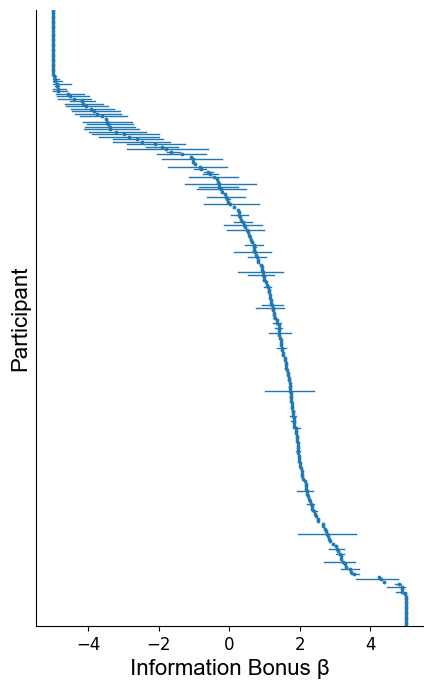

In [310]:
sorted_ids = result_ucb_df.groupby("id").beta.mean().sort_values().index.to_list()
sorted_id_dict = {sorted_ids[i]: i for i in range(len(sorted_ids))}
result_ucb_df["participant_index"] = result_ucb_df.id.map(sorted_id_dict)
from matplotlib.ticker import StrMethodFormatter
fig, ax = plt.subplots(figsize=(5, 8))

sns.pointplot(data=result_ucb_df,
              y="participant_index",
              x="beta", orient="y",
              errorbar=('ci', 99),
              linestyle='', markersize = 2, linewidth=1)

plt.yticks([])

ax.spines[['right', 'top']].set_visible(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
plt.xlabel("Information Bonus β", fontdict={'fontfamily': 'Arial', 'fontsize': 16})
plt.ylabel("Participant", fontdict={'fontfamily': 'Arial', 'fontsize': 16})

Text(0, 0.5, 'Participant')

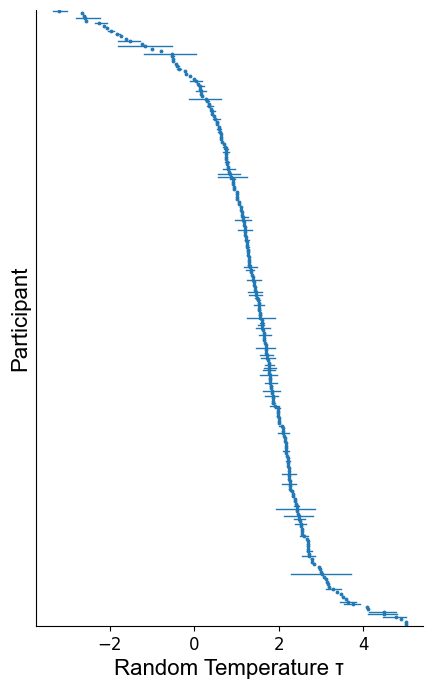

In [311]:
sorted_ids = result_ucb_df.groupby("id").tau.mean().sort_values().index.to_list()
sorted_id_dict = {sorted_ids[i]: i for i in range(len(sorted_ids))}
result_ucb_df["participant_index"] = result_ucb_df.id.map(sorted_id_dict)

from matplotlib.ticker import StrMethodFormatter
fig, ax = plt.subplots(figsize=(5, 8))

sns.pointplot(data=result_ucb_df,
              y="participant_index",
              x="tau", orient="y",
              errorbar=('ci', 99),
              linestyle='', markersize = 2, linewidth=1)

# plt.xticks([])
plt.yticks([])

ax.spines[['right', 'top']].set_visible(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
plt.xlabel("Random Temperature τ", fontdict={'fontfamily': 'Arial', 'fontsize': 16})
plt.ylabel("Participant", fontdict={'fontfamily': 'Arial', 'fontsize': 16})

In [106]:
test = test_new.dropna().groupby("id").mean().reset_index()

In [126]:
test["fun_guassian"] = result_guassian_df.dropna().groupby("id").mean().fun.tolist()

In [181]:
test["ll_null"] = (-14*np.log(1/225))
test["r2_guassian"] = 1-test["fun_guassian"]/test["ll_null"]
test["r2_ucb"] = 1-test["fun"]/test["ll_null"]


meta_test = meta_df_filtered[["id", "age", "gender", "race", "curiosity_je", "curiosity_ds", 
                              "curiosity_st", "curiosity_sc", "curiosity_ts"]]

meta_test = test.merge(meta_test, how="left", on="id")
meta_test["tau"] = -meta_test["tau"] # We transform the tau parameter back to 1/x form by taking its negative, this is because it is estimated as the log(x), and log(1/x) = -log(x)

In [182]:
meta_test.columns

Index(['id', 'success', 'fun', 'lambda', 'tau', 'beta', 'iter', 'll_null',
       'r2_ucb', 'r2_guassian', 'fun_guassian', 'age', 'gender', 'race',
       'curiosity_je', 'curiosity_ds', 'curiosity_st', 'curiosity_sc',
       'curiosity_ts', 'bis', 'soes', 'enjoyment', 'learning_rate'],
      dtype='object')

In [183]:
sns.color_palette(["#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF", "#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF"])

[(0.9019607843137255, 0.29411764705882354, 0.20784313725490197),
 (0.30196078431372547, 0.7333333333333333, 0.8352941176470589),
 (0.0, 0.6274509803921569, 0.5294117647058824),
 (0.23529411764705882, 0.32941176470588235, 0.5333333333333333),
 (0.9529411764705882, 0.6078431372549019, 0.4980392156862745),
 (0.5176470588235295, 0.5686274509803921, 0.7058823529411765),
 (0.5686274509803921, 0.8196078431372549, 0.7607843137254902),
 (0.8627450980392157, 0.0, 0.0),
 (0.49411764705882355, 0.3803921568627451, 0.2823529411764706),
 (0.6901960784313725, 0.611764705882353, 0.5215686274509804)]

In [184]:
sns.color_palette(["#4DBBD5FF", "#8491B4FF"])

[(0.30196078431372547, 0.7333333333333333, 0.8352941176470589),
 (0.5176470588235295, 0.5686274509803921, 0.7058823529411765)]

/home/jasongong/anaconda3/envs/dissertation/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jasongong/anaconda3/envs/dissertation/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0, 0.5, 'Predictive Accuracy')

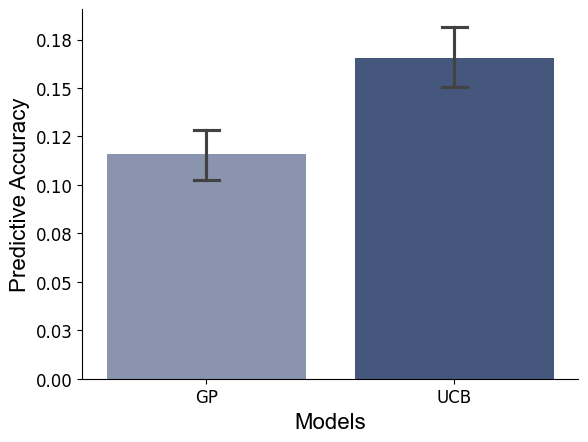

In [244]:
from matplotlib.ticker import StrMethodFormatter
sns.barplot([test.r2_guassian, test.r2_ucb], palette = ["#8491B4FF", "#3C5488FF"], capsize=.1)


sns.despine()
plt.xticks([0, 1], ['GP', 'UCB'], fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
plt.xlabel("Models", fontdict={'fontfamily': 'Arial', 'fontsize': 16})
plt.ylabel("Predictive Accuracy", fontdict={'fontfamily': 'Arial', 'fontsize': 16})

In [188]:
from statsmodels.stats.weightstats import ztest
import scipy
print(ztest(test["r2_guassian"]))
print(test["r2_guassian"].mean())
se = test["r2_guassian"].std()/np.sqrt(test["r2_guassian"].shape[0])
print(se)
critical_z_99 = scipy.stats.norm.ppf(1-.01/2) 
print(test["r2_guassian"].mean() + critical_z_99 * se)
print(test["r2_guassian"].mean() - critical_z_99 * se)

(17.01731295561079, 6.111147039784883e-65)
0.11577924950253146
0.006803615224362305
0.1333042009675153
0.09825429803754761


In [189]:
print(ztest(test["r2_ucb"]- test["r2_guassian"]))
print(test["r2_ucb"].mean())
se = test["r2_ucb"].std()/np.sqrt(test["r2_ucb"].shape[0])
print(se)
critical_z_99 = scipy.stats.norm.ppf(1-.01/2) 
print(test["r2_ucb"].mean() + critical_z_99 * se)
print(test["r2_ucb"].mean() - critical_z_99 * se)

(13.220642910373897, 6.669145441850272e-40)
0.16546331799256236
0.0075344278040975115
0.18487071791583032
0.1460559180692944


In [190]:
meta_test.shape

(245, 23)

In [349]:
sns.color_palette(["#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF", "#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF"])

[(0.9019607843137255, 0.29411764705882354, 0.20784313725490197),
 (0.30196078431372547, 0.7333333333333333, 0.8352941176470589),
 (0.0, 0.6274509803921569, 0.5294117647058824),
 (0.23529411764705882, 0.32941176470588235, 0.5333333333333333),
 (0.9529411764705882, 0.6078431372549019, 0.4980392156862745),
 (0.5176470588235295, 0.5686274509803921, 0.7058823529411765),
 (0.5686274509803921, 0.8196078431372549, 0.7607843137254902),
 (0.8627450980392157, 0.0, 0.0),
 (0.49411764705882355, 0.3803921568627451, 0.2823529411764706),
 (0.6901960784313725, 0.611764705882353, 0.5215686274509804)]

In [238]:
parameter_estimates = pd.melt(meta_test[["tau", "beta"]])
parameter_estimates["value_original"] = np.exp(parameter_estimates.value)

/tmp/ipykernel_595426/585054220.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=parameter_estimates,
/home/jasongong/anaconda3/envs/dissertation/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jasongong/anaconda3/envs/dissertation/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/jasongong/anaconda3/envs/dissertation/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a l

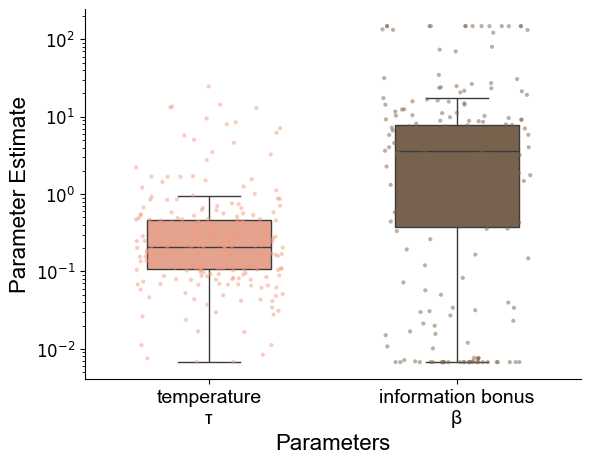

In [239]:
sns.boxplot(data=parameter_estimates,
            x="variable", y="value_original",
            palette = ["#F39B7FFF", "#7E6148FF"],
           width=0.5, showfliers=False)

sns.stripplot(data=parameter_estimates,
              x='variable', y='value_original', palette = ["#F39B7FFF", "#7E6148FF"],
              jitter=0.3, size=3, alpha=0.5)

sns.despine()

plt.xticks([0, 1], ['temperature\nτ', "information bonus\nβ"], fontname = 'Arial', fontsize=14)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))

plt.yscale("log")
plt.xlabel("Parameters", fontdict={'fontfamily': 'Arial', 'fontsize': 16})
plt.ylabel("Parameter Estimate", fontdict={'fontfamily': 'Arial', 'fontsize': 16})
plt.show()

Text(0, 0.5, 'Log Information Bonus\nβ')

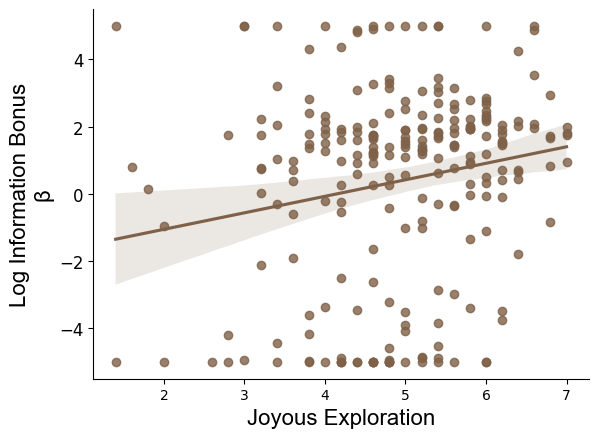

In [240]:
from matplotlib.ticker import StrMethodFormatter
sns.regplot(data=meta_test, x="curiosity_je", y="beta", color = "#7E6148FF")


sns.despine()
plt.yticks(fontsize=12)
plt.xlabel("Joyous Exploration", fontdict={'fontfamily': 'Arial', 'fontsize': 16})
plt.ylabel("Log Information Bonus\nβ", fontdict={'fontfamily': 'Arial', 'fontsize': 16})


Text(0, 0.5, 'Log Temperature\nτ')

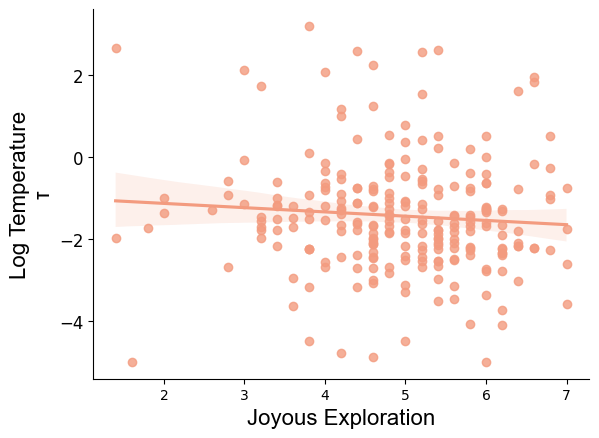

In [241]:
sns.regplot(data=meta_test, x="curiosity_je", y="tau", color = "#F39B7FFF")


sns.despine()
plt.yticks(fontsize=12)
plt.xlabel("Joyous Exploration", fontdict={'fontfamily': 'Arial', 'fontsize': 16})
plt.ylabel("Log Temperature\nτ", fontdict={'fontfamily': 'Arial', 'fontsize': 16})

Text(0, 0.5, 'Log Temperature\nτ')

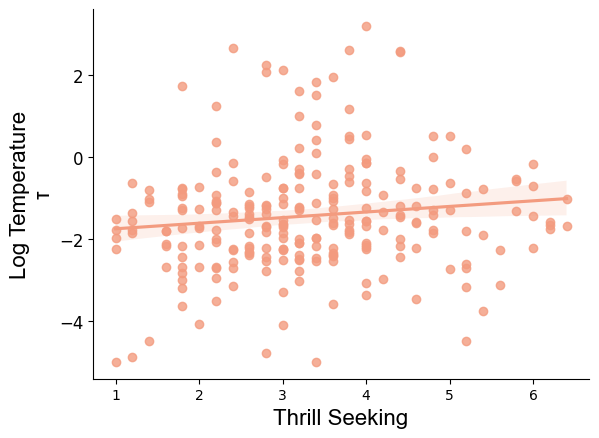

In [243]:
sns.regplot(data=meta_test, x="curiosity_ts", y="tau", color = "#F39B7FFF")


sns.despine()
plt.xlabel("Thrill Seeking", fontdict={'fontfamily': 'Arial', 'fontsize': 16})
plt.ylabel("Log Temperature\nτ", fontdict={'fontfamily': 'Arial', 'fontsize': 16})


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0.5, 0, 'curiosity_ds'),
  Text(1.5, 0, 'curiosity_je'),
  Text(2.5, 0, 'curiosity_st'),
  Text(3.5, 0, 'curiosity_sc'),
  Text(4.5, 0, 'curiosity_ts'),
  Text(5.5, 0, 'age'),
  Text(6.5, 0, 'tau'),
  Text(7.5, 0, 'beta')])

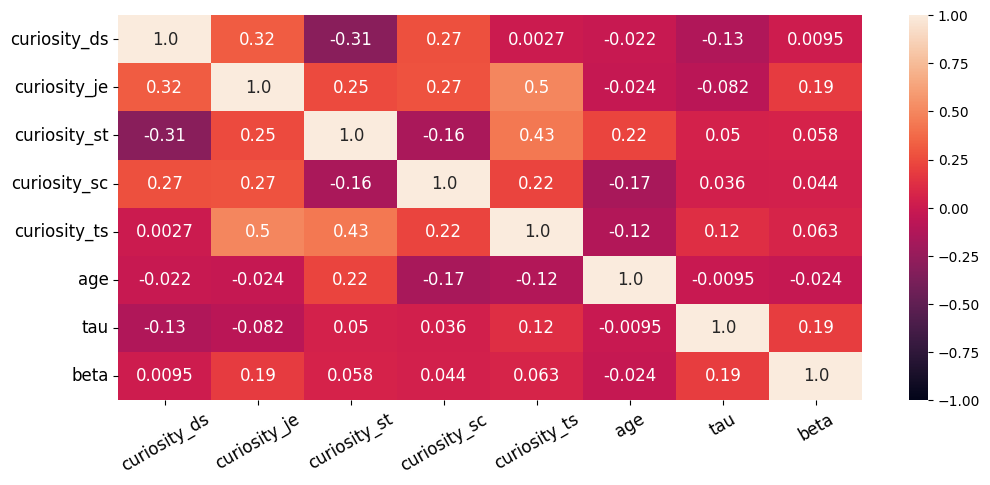

In [254]:
testing_vars = ['curiosity_ds',
                'curiosity_je',
                'curiosity_st',
                'curiosity_sc',
                'curiosity_ts',
                'age',
                'tau',
                'beta']

plt.subplots(figsize=(12, 5))
heatmap = sns.heatmap(meta_test.loc[:, testing_vars].corr(method="pearson"), vmin=-1, vmax=1, annot=True, fmt=".2", annot_kws={"fontsize":12})

plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=30)

In [200]:
meta_test = meta_test.reset_index(drop=True)

In [256]:
meta_test.to_csv("../dissertation/prolific_model_fitting_final.csv")

In [202]:
meta_test = meta_test.rename({"lambda": "lambda_"}, axis=1)

In [245]:
model1 = smf.ols(formula='beta ~ age +curiosity_je + curiosity_ts + curiosity_ds + curiosity_st + curiosity_sc  ', data=meta_test[:]).fit()
model2 = smf.ols(formula='tau ~ age +curiosity_je + curiosity_ts + curiosity_ds + curiosity_st + curiosity_sc ', data=meta_test[:]).fit()
model3 = smf.ols(formula='lambda_ ~ age +curiosity_je + curiosity_ts + curiosity_ds + curiosity_st + curiosity_sc ', data=meta_test[:]).fit()

print(model1.summary())
print(model2.summary())
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                   beta   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.656
Date:                Mon, 13 May 2024   Prob (F-statistic):              0.133
Time:                        10:53:03   Log-Likelihood:                -604.02
No. Observations:                 245   AIC:                             1222.
Df Residuals:                     238   BIC:                             1247.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.4047      1.340     -1.049   

In [255]:
# estimate the regression model again after removing non-significant variables

model1 = smf.ols(formula='beta ~ curiosity_je ', data=meta_test[:]).fit()
model2 = smf.ols(formula='tau ~ curiosity_je + curiosity_ts', data=meta_test[:]).fit()
model3 = smf.ols(formula='lambda_ ~ age +curiosity_je + curiosity_ts + curiosity_ds + curiosity_st + curiosity_sc ', data=meta_test[:]).fit()

print(model1.summary())
print(model2.summary())
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                   beta   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     8.675
Date:                Mon, 13 May 2024   Prob (F-statistic):            0.00354
Time:                        11:17:18   Log-Likelihood:                -604.74
No. Observations:                 245   AIC:                             1213.
Df Residuals:                     243   BIC:                             1220.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.0385      0.841     -2.423   